VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training Deep Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# from tests.unit_tests import test_brick_1, test_brick_2, test_brick_3, test_brick_4, test_brick_5, test_brick_6
# from libs.dkf import DeepKalmanFilter, loss_function

In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


# Modèle

### Structure SSM (Single State Model pour variables latentes + VAE pour observations):

- $z_t$ variables latentes forment une chaîne de Markov, transition $p(z_t \vert z_{t-1})$
- $x_t$ observations, modèle $p_{\theta_x}(x_t \vert z_t)$
- NB : pas de commande/input $u_t$ ici

### Deep Kalman Filter :

\begin{align}
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
d_z(z_{t-1}) &= [ \mu_{\theta_z}(z_{t-1}), \sigma_{\theta_z}(z_{t-1}) ] \\
p_{\theta_x}(x_t \vert z_{t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_{t}), \text{diag}(\sigma_{\theta_x}^{2}(z_{t}))) \\
d_x(z_{t}) &= [ \mu_{\theta_x}(z_{t}), \sigma_{\theta_x}(z_{t}) ] \\
\end{align}

où $d_x, d_z$ sont des réseaux.

### Modèle inférence

Le "true posterior" s'écrit :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
&= \prod_{t=1}^T p_{\theta} (z_t \vert z_{t-1}, x_{t:T} )
\end{align}

où la première écriture est l'application de la chain rule, et la deuxième est un résultat de D-séparation (latentes à dépendance Markovienne).

On choisit comme approximation du posterior (=encodeur) une formulation calquée sur le vrai posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{t-1}, x_{t:T})
\end{align}

On voit que l'inférence prend en compte les observations futures $x_{t:T}$ (comme le Kalman smoother par exemple)

# Implémentation de l'inférence

- **backward RNN** (dans les faits, un LSTM) pour encoder les $x_{t:T}$ par les hidden states $h_t$ : 

\begin{align}
h_t = \text{LSTM}(h_{t+1}, x_t)
\end{align}

- **combiner** (réseau MLP) pour aggréger $h_t$ et $z_{t-1}

\begin{align}
g_t = \text{Combiner}(h_t, z_{t-1})
\end{align}

- **Encoder** (réseau MLP) pour inférer les paramètres du posterior:

\begin{align}
e_z(g_t) &= [ \mu_\phi(g_t), \sigma_\phi(g_t)] \\
q_\phi(z_t \vert g_t) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t)))
\end{align}

NB : il existe d'autres formulations du posterior approximé $q_\phi$, qui peuvent faire intervenir un forward LSTM.

# Training

Le modèle s'entraîne en maximisant un ELBO, dont la formulation générique se simplifie dans le cas du DKF en :

\begin{align}
\mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T \mathbb{E}_{q_\phi(z_t \vert x_{1:T})} \log(p_{\theta_x}(x_t \vert z_t)) -
\sum_{t=1}^T \mathbb{E}_{q_\phi(z_{t-1} \vert x_{1:T})} \text{D}_{\text{KL}} \left[ q_\phi(z_t \vert z_{-1}, x_{t:T}) \vert\vert 
p_{\theta_z}(z_t \vert z_{t-1}) \right]
\end{align}

Les deux termes s'explicitent de la façon suivante (avec $D$ dimension de l'espace des observations) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) \right)
\end{align}

Et la KL entre les deux Gaussiennes:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

a une close form (avec $Z$ dimension de l'espace latent):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^D \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align}

# Code

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 16 # Dimension of the latent space
H_DIM = 128 # Dimension of the hidden state of the LSTM network(s)
G_DIM = 8 # Dimension of the output of the combiner
INTERMEDIATE_LAYER_DIM = 16 # Dimension of the intermediate layers of the MLPs

### Briques de base

In [6]:
#--- brick 1 : backward LSTM -----------------------------

class BackwardLSTM(nn.Module):
    """
    Backward LSTM module.
    """
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(BackwardLSTM, self).__init__()
        
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size,   # dimension of the observation space
            hidden_size,  # dimension of the hidden state of the LSTM network
            num_layers=num_layers, # number of layers of the LSTM network
            batch_first=False, # using the default PyTorch LSTM implementation, expecting input shape (seq_len, batch, input_size)
            bidirectional=False # unidirectional LSTM to start with
            )

    def forward(self, x):
        # Reverse the input sequence - axis 0 is the time axis here
        x_reversed = torch.flip(x, [0])
        # Pass through LSTM
        # using initial hidden state and cell state as zeros
        out, _ = self.lstm(x_reversed)
        # Reverse the output sequence
        out_reversed = torch.flip(out, [0])
        # return output shape (seq_len, batch, hidden_size)
        
        return out_reversed

In [7]:
#--- brick 2 : combiner -----------------------------
#
# this combines the latent variable at time t-1
# with the hidden state from the backward LSTM at time t,
# to compute a tX_DIM = 1 # Dimension of the observation space
Z_DIM = 16 # Dimension of the latent space
H_DIM = 16 # Dimension of the hidden state of the LSTM network(s)
G_DIM = 8 # Dimension of the output of the combiner
INTERMEDIATE_LAYER_DIM = 16 # Dimension of the intermediate layers of the MLPsensor g at time t, that will be used
# to compute the parameters of the approximate posterior distribution
# of the latent variable
#

class CombinerMLP(nn.Module):
    """Combiner module. Takes the hidden state of the backward LSTM at time t
    and the latent variable at time t-1, to compute a tensor g at time t,
    that will be used to compute the parameters of the approximate posterior
    distribution of the latent variable.

    Args:
        nn (_type_): _description_
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, 
                 hidden_dim=H_DIM, 
                 output_dim=G_DIM,
                 layers_dim = None,  # list of layers dimensions, without the input dimnesion, without the output dimension
                 activation = 'tanh',
                 inter_dim = INTERMEDIATE_LAYER_DIM,
                 ):
        super(CombinerMLP, self).__init__()
        
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        self.inter_dim = inter_dim
        self.layers_dim = layers_dim
        
        if self.layers_dim is None:
            self.layers_dim = [self.inter_dim] * 2
        else:
            self.layers_dim = layers_dim
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(self.layers_dim):
            if i==0:  #first layer, latent_dim + hidden_dim => layers_dim[0]
                layers.append(nn.Linear(latent_dim + hidden_dim, dim))
            else:  # all other layers
                layers.append(nn.Linear(self.layers_dim[i-1], dim))
            layers.append(self.activation_fn)
        # last layer : layers_dim[-1] => output_dim
        layers.append(nn.Linear(self.layers_dim[-1], output_dim))
            
        # build the MLP
        self.mlp = nn.Sequential(*layers)
            
        
    def forward(self, h, z):
        """
        Forward pass of the combiner module.
        Args:
            h: hidden state of the backward LSTM at time t
            shape (batch, hidden_dim)
            z: latent variable at time t-1
            shape (batch, latent_dim)
        Returns:
            g: tensor g at time t
            shape (batch, output_dim)
        """
        
        # Concatenate the hidden state and the latent variable on their dimension
        x = torch.cat((h, z), dim=-1)
        
        # Pass through MLP
        g = self.mlp(x)
        
        return g     

In [8]:
#--- brick 3 : Encoder -----------------------------
#
# This computes the parameters of the approximate posterior distribution
# of the latent vatiable at time t.
# The approximate posterior distribution is a Gaussian distribution,
# we use a MLP to compute the mean and the log of the variance.
#

class EncoderMLP(nn.Module):
    """Encoder module. Computes the parameters of the approximate posterior
    distribution of the latent variable at time t. The approximate posterior
    distribution is a Gaussian distribution, we use a MLP to compute the mean
    and the log of the variance.

    Args:
        nn (_type_): _description_
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, # Dimension of the latent space
                 combiner_dim=G_DIM, # Dimension of the combiner output
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 layers_dim = None, # Dimension of the MLP layers (without inout nor output)
                 activation = 'tanh', # Activation function
    ):
        super(EncoderMLP, self).__init__()
        
        self.latent_dim = latent_dim
        self.combiner_dim = combiner_dim
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        self.inter_dim = inter_dim
        
        if layers_dim is None:
            self.layers_dim = [self.inter_dim] * 2
        else:
            self.layers_dim = layers_dim
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(self.layers_dim):
            if i==0:
                layers.append(nn.Linear(combiner_dim, dim))
            else:
                layers.append(nn.Linear(self.layers_dim[i-1], dim))
            layers.append(self.activation_fn)
            
        # last layer is linear, no activation
        layers.append(nn.Linear(self.layers_dim[-1], 2 * latent_dim)) 
                    
        # build the MLP
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, g):
        """
        Forward pass of the encoder module.
        
        Args:
            g: tensor g at time t
            shape (batch, combiner_dim)
            
        Returns:
            mu: mean of the approximate posterior distribution
            shape (batch, latent_dim)
            logvar: log of the variance of the approximate posterior distribution
            shape (batch, latent_dim)
        """
        
        # Pass through MLP
        out = self.mlp(g)
        
        # Split the output into mean and log variance
        # each with shape (batch, latent_dim)
        mu, logvar = out[:, :self.latent_dim], out[:, self.latent_dim:]
        
        return mu, logvar

In [9]:
#--- brick 4 : Latent Space Transition -----------------------------       
#
# This computes the parameters of the transition distribution
# of the latent variable at time t. Ie the prior distribution, 
# before inference.
# The transition distribution is a Gaussian distribution,
# we use a MLP to compute the mean and the log of the variance.
#

class LatentSpaceTransitionMLP(nn.Module):
    """Latent space transition module. Computes the parameters of the
    transition distribution of the latent variable at time t. The transition
    distribution is a Gaussian distribution, we use a MLP to compute the mean
    and the log of the variance.

    Args:
        nn (_type_): _description_
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, # Dimension of the latent space
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 layers_dim = None, # Dimension of the MLP layers
                 activation = 'tanh', # Activation function
    ):
        super(LatentSpaceTransitionMLP, self).__init__()
        
        self.latent_dim = latent_dim
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        self.inter_dim = inter_dim
        
        if layers_dim is None:
            layers_dim = [self.inter_dim] * 2
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(layers_dim):
            if i==0:
                layers.append(nn.Linear(latent_dim, dim))
            else:
                layers.append(nn.Linear(layers_dim[i-1], dim))
            layers.append(self.activation_fn)
            
        # last layer is linear, no activation
        layers.append(nn.Linear(layers_dim[-1], 2 * latent_dim)) 
                    
        # build the MLP
        self.mlp = nn.Sequential(*layers)
               
    def forward(self, z):
        """
        Forward pass of the latent space transition module.
        
        Args:
            z: latent variable at time t-1
            shape (seq_len, batch, latent_dim)
            
        Returns:
            mu: mean of the transition distribution
            shape (seq_len, batch, latent_dim)
            logvar: log of the variance of the transition distribution
            shape (seq_len, batch, latent_dim)
        """
        
        # Pass through MLP
        out = self.mlp(z)
        
        # Split the output into mean and log variance
        # each with shape (batch, latent_dim)
        mu, logvar = out[:, :, :self.latent_dim], out[:, :, self.latent_dim:]
        
        return mu, logvar

In [10]:
#--- brick 5 : Decoder (ie Observation Model) -----------------------------
#
# This computes the parameters of the distribution of 
# the observed variable 'x', given the latent variable 'z'.
# The distribution is a Gaussian distribution,
# we use a MLP to compute the mean and the log of the variance.
#

class DecoderMLP(nn.Module):
    """Decoder module. Computes the parameters of the distribution of the
    observed variable 'x', given the latent variable 'z'. The distribution is
    a Gaussian distribution, we use a MLP to compute the mean and the log of
    the variance.

    Args:
        nn (_type_): _description_
    
    """
    
    def __init__(self, 
                 latent_dim=Z_DIM, # Dimension of the latent space
                 observation_dim=X_DIM, # Dimension of the observation space
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 layers_dim = None, # Dimension of the MLP layers
                 activation = 'tanh', # Activation function
    ):
        super(DecoderMLP, self).__init__()
        
        self.latent_dim = latent_dim
        self.observation_dim = observation_dim
        self.inter_dim = inter_dim
        
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()
        else:
            raise ValueError(f"Activation function {activation} not supported. Use 'tanh' or 'relu'.")
        
        if layers_dim is None:
            layers_dim = [self.inter_dim] * 2 # layers per default
            
        # explicitly define the MLP layers
        layers = []
        for i, dim in enumerate(layers_dim):
            if i==0:
                layers.append(nn.Linear(latent_dim, dim))
            else:
                layers.append(nn.Linear(layers_dim[i-1], dim))
            layers.append(self.activation_fn)
            
        # last layer is linear, no activation
        layers.append(nn.Linear(layers_dim[-1], 2 * self.observation_dim)) 
                    
        # build the MLP
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, z):
        """
        Forward pass of the decoder module.
        Args:
            z: latent variable at time t
            shape (seq_len, batch, latent_dim)
        Returns:
            mu: mean of the distribution of the observed variable
            shape (seq_len, batch, observation_dim)
            logvar: log of the variance of the distribution of the observed variable
            shape (seq_len, batch, observation_dim)
        """
        # Pass through MLP
        out = self.mlp(z)
        
        # Split the output into mean and log variance
        # each with shape (batch, observation_dim)
        mu, logvar = out[:, :, :self.observation_dim], out[:, :, self.observation_dim:]
        
        return mu, logvar

In [11]:
# --- brick 6 : Sampler with reparameterization trick -----------------------------
#
# This samples from a normal distribution of given mean and log variance
# using the reparameterization trick.

class Sampler(nn.Module):
    """Sampler module. Samples from a normal distribution of given mean and
    log variance using the reparameterization trick.

    Args:
        nn (_type_): _description_
    """
    
    def __init__(self):
        super(Sampler, self).__init__()
        
    def forward(self, mu, logvar):
        """
        Forward pass of the sampler module.
        
        Args:
            mu: mean of the distribution
            shape (batch, dim)
            logvar: log of the variance of the distribution
            shape (batch, dim)
            
        Returns:
            v: sampled variables
            shape (batch, dim)
        """
        
        # Sample from a normal distribution using the reparameterization trick
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)  # random noise
        v = mu + eps * std  # sampled variables
        
        return v

# Class DeepKalman Filter

In [12]:
class DeepKalmanFilter(nn.Module):
    """
    Deep Kalman Filter (DKF) module. Implements the DKF algorithm.
    
    Args:
        nn (_type_): _description_
        
    Returns:
        _type_: _description_
    """
    
    def __init__(self,
                 input_dim=X_DIM, # Dimension of the observation space
                 latent_dim=Z_DIM, # Dimension of the latent space
                 hidden_dim=H_DIM, # Dimension of the hidden state of the LSTM network
                 combiner_dim=G_DIM, # Dimension of the combiner output
                 inter_dim=INTERMEDIATE_LAYER_DIM, # Dimension of the intermediate layers
                 activation='tanh', # Activation function
                 num_layers=1, # Number of layers of the LSTM network
                 device='cpu' # Device to use (cpu or cuda)
                 ):
        super(DeepKalmanFilter, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.combiner_dim = combiner_dim
        self.inter_dim = inter_dim
        self.device = device
        
        # define the modules
        
        self.backward_lstm = BackwardLSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=num_layers
        )
        
        self.combiner = CombinerMLP(
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            output_dim=self.combiner_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
            inter_dim=self.inter_dim
        )
        
        self.encoder = EncoderMLP(
            latent_dim=self.latent_dim,
            combiner_dim=self.combiner_dim,
            inter_dim=self.inter_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
        )
        
        self.latent_space_transition = LatentSpaceTransitionMLP(
            latent_dim=self.latent_dim,
            inter_dim=self.inter_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
        )
        
        self.decoder = DecoderMLP(
            latent_dim=self.latent_dim,
            observation_dim=self.input_dim,
            inter_dim=self.inter_dim,
            activation=activation,
            layers_dim=None, # list of layers dimensions, without the input dimension, without the output dimension
        )
        
        self.sampler = Sampler()
        
    def forward(self, x):
        """
        Forward pass of the Deep Kalman Filter. Runs one step inference
        
        Args:
            x: input sequence
            shape (seq_len, batch, input_dim)
        Returns:
        
        """
        
        # we assume that the input sequence is of shape (seq_len, batch, input_dim)
        seq_len, batch_size, input_dim = x.shape
        assert input_dim == self.input_dim, f"Input dimension {input_dim} does not match the expected dimension {self.input_dim}"
        
        # initialize the latent variable at time t=0
        # NB : in INRIA code : self.register_buffer
        # "If you have parameters in your model, which should be saved and restored in the state_dict, 
        # but not trained by the optimizer, you should register them as buffers.
        # Buffers won’t be returned in model.parameters(), 
        # so that the optimizer won’t have a change to update them.#
        z0 = torch.zeros(batch_size, self.latent_dim).to(self.device)
        # initialize the hidden state of the backward LSTM at time t=0
        # NB : they are not used in a first version of this code
        h0 = torch.zeros(batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(batch_size, self.hidden_dim).to(self.device)
        # initialize the outputs
        # mu_x_s, logvar_x_s = torch.zeros(seq_len, batch_size, self.input_dim).to(self.device), torch.zeros(seq_len, batch_size, self.input_dim).to(self.device)
        mu_z_s, logvar_z_s = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device), torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
        # mu_z_transition_s, logvar_z_transition_s = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device), torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
        
        # run the backward LSTM on the input sequence
        # outputs are the hidden states, shape (seq_len, batch, hidden_dim)
        h_t_s = self.backward_lstm(x)
        
        # loop to compute the approximate posterior distribution of the latent variables z_t
        # given the observations x_t
        # initialize the sequence of sampled latent variables z_t
        sampled_z_t_s = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
        
        for t in range(seq_len):
            # at time t, get z_t-1 and h_t
            if t == 0:
                sampled_z_t_1 = z0
            else:
                sampled_z_t_1 = sampled_z_t_s[t-1]
            h_t = h_t_s[t]
            # compute g_t
            g_t = self.combiner(h_t, sampled_z_t_1)
            # compute the parameters of the approximate posterior distribution
            mu_z, logvar_z = self.encoder(g_t)
            mu_z_s[t], logvar_z_s[t] = mu_z, logvar_z
            # sample z_t and store it
            sampled_z_t = self.sampler(mu_z, logvar_z)
            sampled_z_t_s[t] = sampled_z_t
            
        # compute the parameters of the transition distribution
        z_t_lagged = torch.cat([z0.unsqueeze(0), sampled_z_t_s[:-1]])  # lagged z_t
        mu_z_transition_s, logvar_z_transition_s = self.latent_space_transition(z_t_lagged)
        
        # compute the parameters of the observation distribution
        mu_x_s, logvar_x_s = self.decoder(sampled_z_t_s)
            
        # return the outputs
        return x, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s
    
    def __repr__(self):
        
        msg = f"DeepKalmanFilter(input_dim={self.input_dim}, latent_dim={self.latent_dim}, hidden_dim={self.hidden_dim}, combiner_dim={self.combiner_dim}, inter_dim={self.inter_dim})"
        msg += f"\n{self.backward_lstm}"
        msg += f"\n{self.combiner}"
        msg += f"\n{self.encoder}"
        msg += f"\n{self.latent_space_transition}"
        msg += f"\n{self.decoder}"
        msg += f"\n{self.sampler}"
        
        return msg
    
    
    def predict(self, x, num_steps):
        """
        Predicts future steps based on the input sequence.

        Args:
            x (torch.Tensor): Input tensor of shape (seq_len, batch_size, x_dim).
            num_steps (int): Number of future steps to predict.

        Returns:
            predicitons (torch.Tensor): Tensor of shape (num_steps, batch_size, x_dim)
            containing the predicted future steps.
            full_x (torch.Tensor): Tensor of shape (seq_len + num_steps, batch_size, x_dim)
            containing the reconstrcuted input sequence and the predicted future steps.
            
            
        """
        
        with torch.no_grad():
            
            # run an inference forward pass to learn the latent variable transition probability distrubution
            seq_len, batch_size, input_dim = x.shape
            assert input_dim == self.input_dim, f"Input dimension {input_dim} does not match the expected dimension {self.input_dim}"
            
            z0 = torch.zeros(batch_size, self.latent_dim).to(self.device)
            # initialize the hidden state of the backward LSTM at time t=0
            # NB : they are not used in a first version of this code
            h0 = torch.zeros(batch_size, self.hidden_dim).to(self.device)
            c0 = torch.zeros(batch_size, self.hidden_dim).to(self.device)
            
            # initialize the outputs
            mu_z_s, logvar_z_s = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device), torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
            
            # run the backward LSTM on the input sequence
            # outputs are the hidden states, shape (seq_len, batch, hidden_dim)
            h_t_s = self.backward_lstm(x)
            
            # loop to compute the approximate posterior distribution of the latent variables z_t
            # given the observations x_t
            # initialize the sequence of sampled latent variables z_t
            sampled_z_t_s = torch.zeros(seq_len, batch_size, self.latent_dim).to(self.device)
            
            for t in range(seq_len):
                # at time t, get z_t-1 and h_t
                if t == 0:
                    sampled_z_t_1 = z0
                else:
                    sampled_z_t_1 = sampled_z_t_s[t-1]
                h_t = h_t_s[t]
                # compute g_t
                g_t = self.combiner(h_t, sampled_z_t_1)
                # compute the parameters of the approximate posterior distribution
                mu_z, logvar_z = self.encoder(g_t)
                mu_z_s[t], logvar_z_s[t] = mu_z, logvar_z
                # sample z_t and store it
                sampled_z_t = self.sampler(mu_z, logvar_z)
                sampled_z_t_s[t] = sampled_z_t
                
            # compute the parameters of the transition distribution
            z_t_lagged = torch.cat([z0.unsqueeze(0), sampled_z_t_s[:-1]])  # lagged z_t
            mu_z_transition_s, logvar_z_transition_s = self.latent_space_transition(z_t_lagged)
            
            # compute the parameters of the observation distribution
            mu_x_s, logvar_x_s = self.decoder(sampled_z_t_s)
            
            # Start with the last inferred latent state
            z_pred = sampled_z_t_s[-1:, :, :]

            # Start to predict x at the end of the given sequence
            predictions = torch.zeros(num_steps, batch_size, self.input_dim).to(self.device)
            logvar_predictions = torch.zeros(num_steps, batch_size, self.input_dim).to(self.device)
            
            for s in range(num_steps):
                # Get the parameters (mean and variance) of the transition
                # distribution p(z_t|z_{t-1})
                z_pred_mean, z_pred_logvar = self.latent_space_transition(z_pred)

                # Sample from p(z_t|z_{t-1}) distribution
                z_pred = self.sampler(z_pred_mean, z_pred_logvar)
                
                x_pred, logvar_x_pred = self.decoder(z_pred)
                
                predictions[s,:,:] = x_pred
                logvar_predictions[s,:,:] = logvar_x_pred

        # Append predictions to the reconstructed x
        full_x = torch.cat([mu_x_s, predictions], dim=0)
        full_logvar_x = torch.cat([logvar_x_s, logvar_predictions], dim=0)
        
        return predictions, logvar_predictions, full_x, full_logvar_x

# Loss function

In [13]:
def loss_function(x, x_hat, x_hat_logvar, z_mean, z_logvar,
                  z_transition_mean, z_transition_logvar, beta=None):
    """
    Compute the total loss for a variational autoencoder (VAE) with a weighted 
    reconstruction loss and a Kullback-Leibler (KL) divergence term.

    Parameters:
    -----------
    x : torch.Tensor
        Ground truth data with shape (seq_len, batch_size, x_dim).
    x_hat : torch.Tensor
        Reconstructed data from the VAE with shape
        (seq_len, batch_size, x_dim).
    x_hat_logvar : torch.Tensor
        Log variance of the reconstructed data with shape
        (seq_len, batch_size, x_dim).
    z_mean : torch.Tensor
        Mean of the latent variable distribution with shape 
        (seq_len, batch_size, x_dim).
    z_logvar : torch.Tensor
        Log variance of the latent variable distribution with shape 
        (seq_len, batch_size, x_dim).
    z_transition_mean : torch.Tensor
        Mean of the transition distribution in the latent space with shape 
        (seq_len, batch_size, x_dim).
    z_transition_logvar : torch.Tensor
        Log variance of the transition distribution in the latent space with 
        shape (seq_len, batch_size, x_dim).
    beta : float
        Weighting factor for the KL divergence term.
    loss_type : str
        Type of reconstruction loss to use. Options:
        - 'mse': Mean Squared Error (MSE) loss.
        - 'weighted_mse': Weighted Mean Squared Error (MSE) loss.

    Returns:
    --------
    total_loss : torch.Tensor
        The total loss, which is the sum of the reconstruction loss and the 
        KL divergence loss.

    Notes:
    ------
    - The "reconstruction loss" is based on formula above
    - The KL divergence loss measures the difference between the latent
      variable distribution and the transition distribution in the latent space.
    - Both losses are normalized by the sequence length (`seq_len`) and
      averaged over the batch.
    - The total loss is a combination of the reconstruction loss and the 
      KL divergence loss, weighted by the `beta` parameter.
    """
    
    # beta
    if beta is None:
        beta = 1.0
        
    seq_len, batch_size, x_dim = x.shape
    
    # Compute the reconstruction loss
    var = x_hat_logvar.exp()
    loss = torch.div((x - x_hat)**2, var)
            
    loss += x_hat_logvar
    loss = loss.sum(dim=2)  # Sum over the x_dim
    loss = loss.sum(dim=0)  # Sum over the sequence length
    loss = loss.mean()  # Mean over the batch
    reconstruction_loss = loss / seq_len
           
    # Compute the KL divergence loss
    kl_loss = (z_transition_logvar - z_logvar +
               torch.div((z_logvar.exp() + 
                         (z_transition_mean - z_mean).pow(2)),
                         z_transition_logvar.exp()))
    
    kl_loss = kl_loss.sum(dim=2)  # Sum over the z_dim
    kl_loss = kl_loss.sum(dim=0)  # Sum over the sequence length
    kl_loss = kl_loss.mean()  # Mean over the batch
    kl_loss = kl_loss / seq_len
                
    # Combine the reconstruction loss and the KL divergence loss
    total_loss = (reconstruction_loss + beta * kl_loss)/(1+beta)
    
    return reconstruction_loss, kl_loss, total_loss

# Toy Case : Data Generation for Time Series Forecasting

In [14]:
n_steps = 50
n_ahead = 10
n_series = 1000

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.8 * np.sin((time - o1) * (f1 * 40 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o1) * (f1 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [15]:
s = generate_time_series(n_series, n_steps+n_ahead)

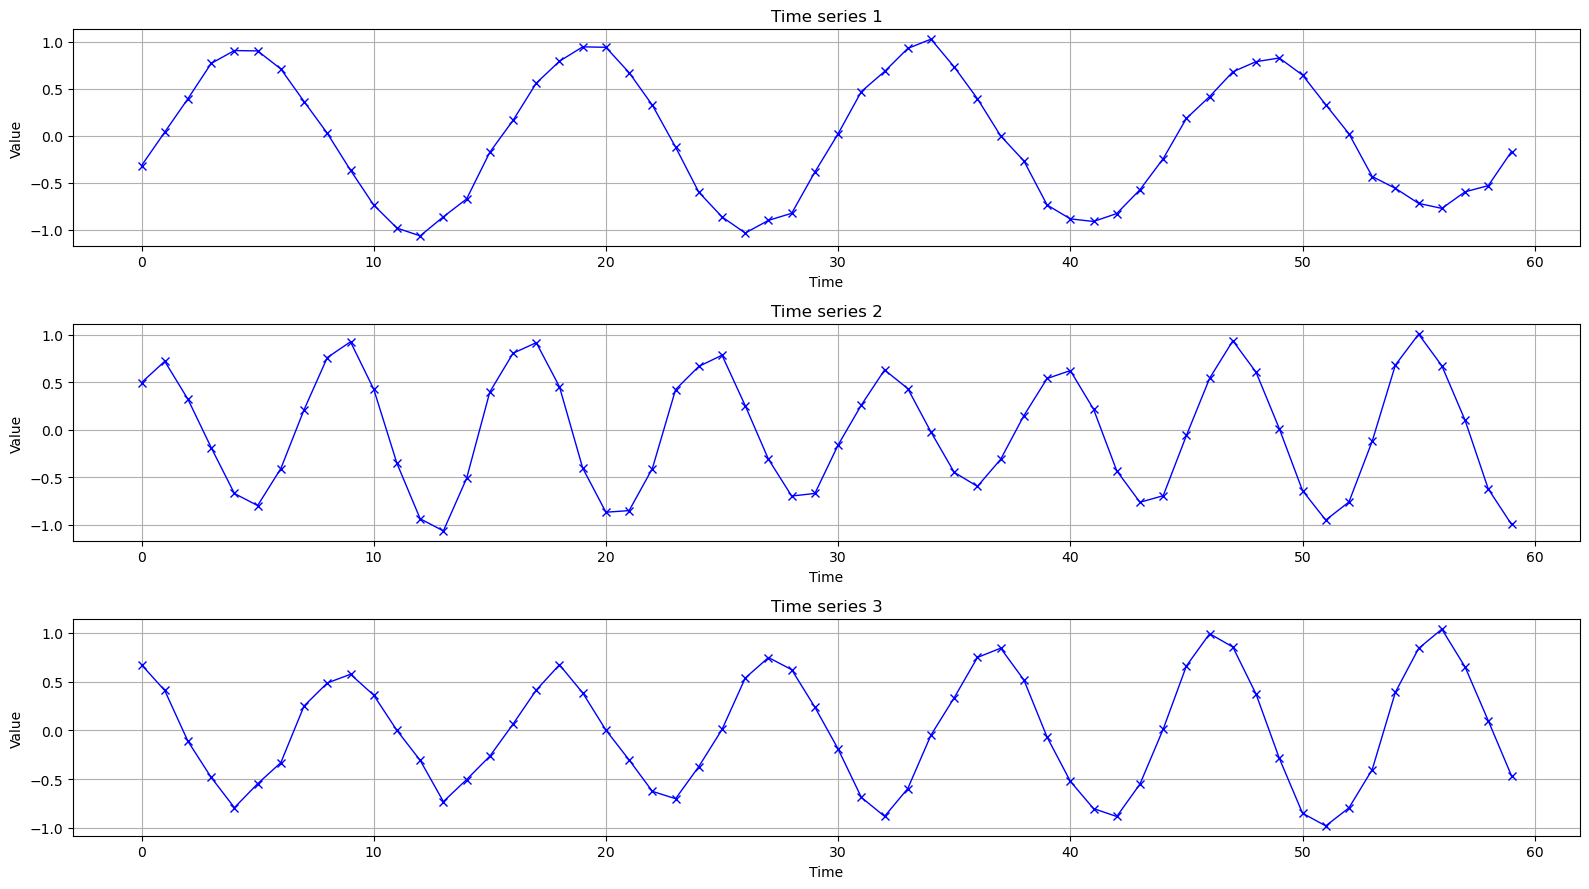

In [16]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [17]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (800, 50)
y_train shape: (800, 10)
X_valid shape: (200, 50)
y_valid shape: (200, 10)


In [18]:
# form datasets, dataloaders, etc

BATCH_SIZE = 512   # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Baseline : RNN

In [19]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=n_ahead, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [20]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=n_ahead,
    hidden_dim=128,
    num_layers=4,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [21]:
# Test dimensions

x = torch.randn(BATCH_SIZE, 50, 1).to(device)
y = rnn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {y.shape}")

input shape: torch.Size([512, 50, 1])
output shape: torch.Size([512, 10, 1])


In [22]:
def loss_rnn(y, y_hat):
    """
    Compute the loss for the RNN model.
    
    Args:
        y: target values - shape is (seq_len, batch_size, output_dim)
        y_hat: predicted values - shape is (seq_len, batch_size, output_dim)
    Returns:
        loss: MSE loss
    """
    
    seq_len = y.shape[0]
    batch_size = y.shape[1]
    output_dim = y.shape[2]
    
    # compute the loss
    loss = (y - y_hat)**2
    # print(loss.shape)
    loss = torch.sum(loss, dim=2)  # Sum over the output dimension
    loss = torch.sum(loss, dim=0)  # Sum over the sequence length
    loss = torch.sqrt(loss)  # Square root of the sum
    loss = torch.mean(loss)  # Mean over the batch
    loss = loss / seq_len
    
    return loss

criterion = nn.MSELoss()
# criterion = loss_rnn

In [23]:
lr = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
num_epochs = 100

In [24]:
train_losses = []
valid_losses = []

print(f"Start training RNN model for {num_epochs} epochs")

for i in range(num_epochs):
    # loop on training data
    rnn.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, n_ahead, 1)
        # print(f"target has shape {target.shape}")
        output = rnn(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader) 
    train_losses.append(epoch_loss)
    
    # test step
    rnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, n_ahead, 1)
            output = rnn(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(test_loader)
    valid_losses.append(epoch_loss)
    
    # report out
    if (i+1) % 5 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

Start training RNN model for 100 epochs
epoch    5/100, training loss = 3.6874e-01, validation loss = 3.8745e-01
epoch   10/100, training loss = 3.5661e-01, validation loss = 3.7538e-01
epoch   15/100, training loss = 3.3832e-01, validation loss = 3.5233e-01
epoch   20/100, training loss = 3.1231e-01, validation loss = 3.2140e-01
epoch   25/100, training loss = 2.8572e-01, validation loss = 2.9345e-01
epoch   30/100, training loss = 2.6334e-01, validation loss = 2.7959e-01
epoch   35/100, training loss = 2.5149e-01, validation loss = 2.7076e-01
epoch   40/100, training loss = 2.4344e-01, validation loss = 2.4456e-01
epoch   45/100, training loss = 2.3268e-01, validation loss = 2.4615e-01
epoch   50/100, training loss = 2.1516e-01, validation loss = 2.1957e-01
epoch   55/100, training loss = 2.0817e-01, validation loss = 2.0524e-01
epoch   60/100, training loss = 1.9700e-01, validation loss = 1.9560e-01
epoch   65/100, training loss = 1.8812e-01, validation loss = 1.8904e-01
epoch   70/

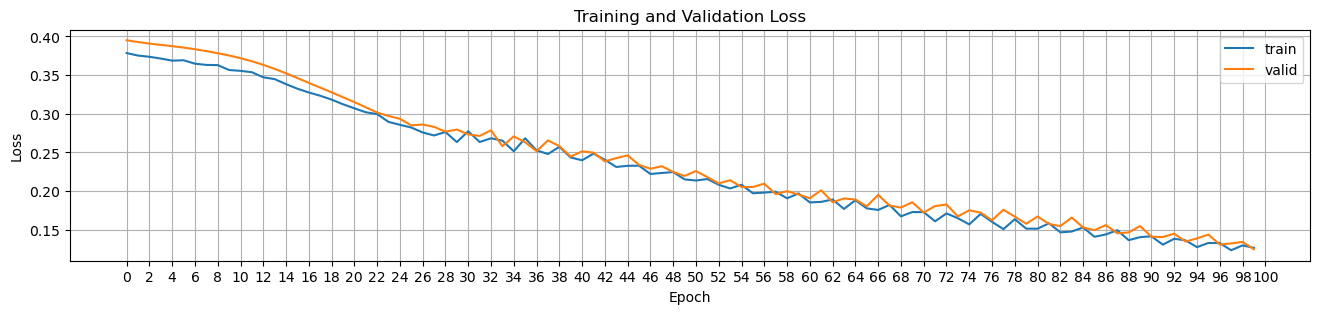

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, num_epochs+1, 2))
ax.set_xticklabels(np.arange(0, num_epochs+1, 2))
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.grid()
plt.show()

In [26]:
y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device).unsqueeze(-1)

# print(f"y_target shape: {y_target.shape}")
# print(f"y_pred shape: {y_pred.shape}")

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

# print(f"\n{np.mean(np.sqrt((y_target - y_pred) ** 2)):.4f} RMSE")

Loss finale = 1.2472e-01


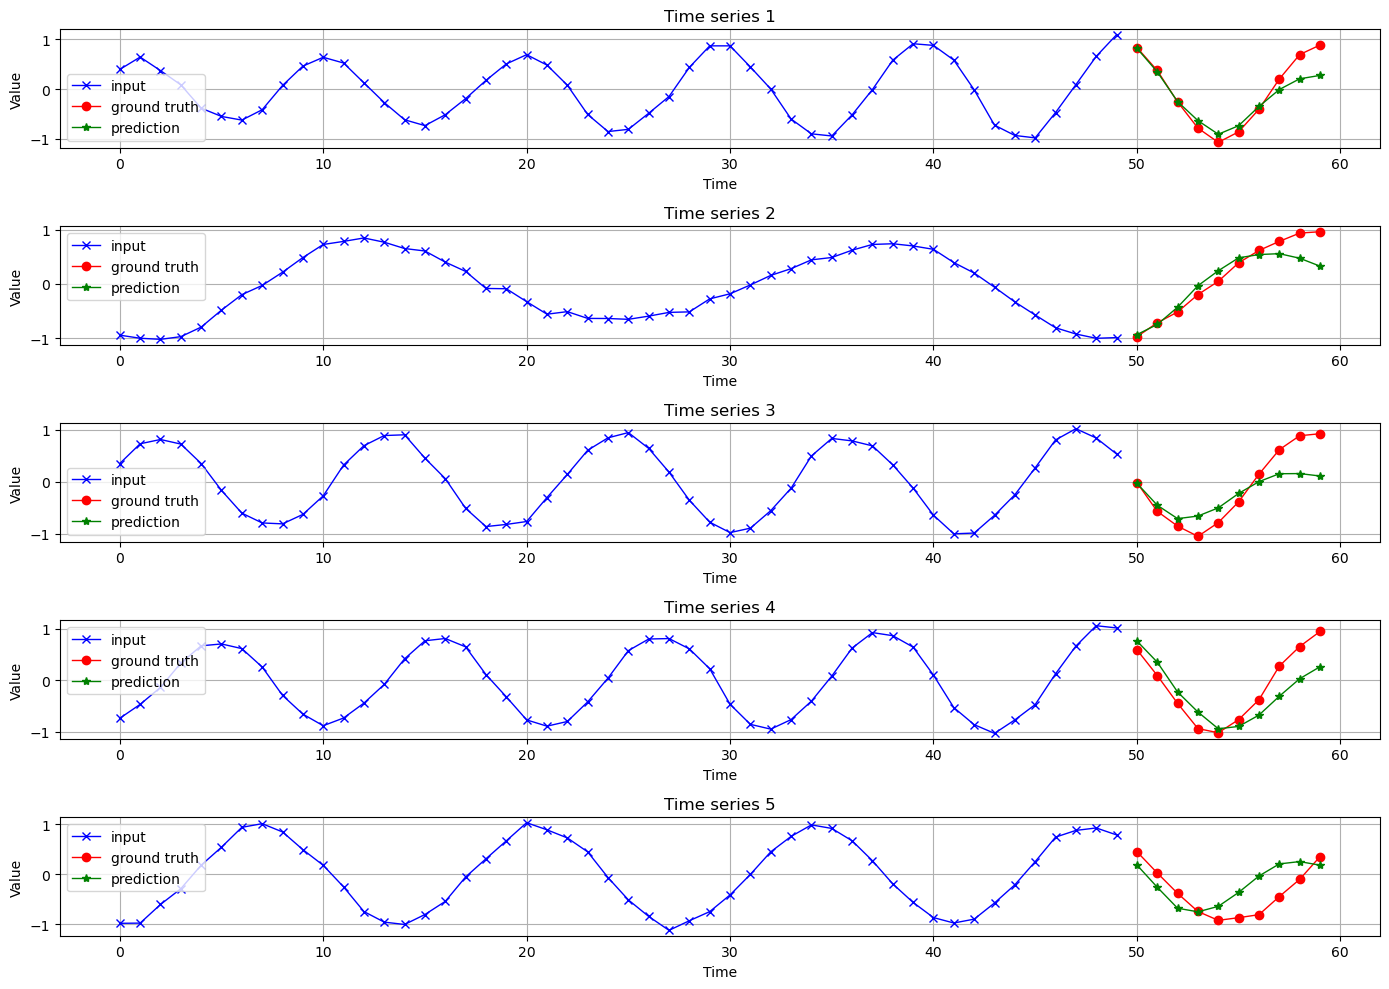

In [27]:
N = 5
fig, ax  = plt.subplots(N, 1, figsize=(14, 2 * N))
x_shift = X_valid.shape[-1]

for i in range(N):
    input = torch.tensor(X_valid[i], device=device).unsqueeze(0).unsqueeze(-1)
    # input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_valid[i], device=device).view(-1, n_ahead, 1)
    # target = target.permute(1, 0, 2)  # permute to (seq_len, batch_size, output_dim)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    
    ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
    ax[i].set_title(f"Time series {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Value")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

### Training DKF

In [28]:
# Training step : perform training for one epoch

def train_step(model, optimizer, loss_fn, train_loader=train_loader, device=device, beta=None):
    ### training step
    model.train()
    optimizer.zero_grad()
    ### loop on training data
    rec_loss = 0
    kl_loss = 0
    epoch_loss = 0
    
    for input, _ in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)

        _, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s = model(input)
        
        rec_loss, kl_loss, total_loss = loss_fn(input, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s, beta=beta)
        
        total_loss.backward()
        optimizer.step()
              
        rec_loss += rec_loss.item()
        kl_loss += kl_loss.item()
        epoch_loss += total_loss.item()
        
    epoch_loss /= len(train_loader)
    rec_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [29]:
# Test step : perform validation test for one epoch

def test_step(model, optimizer, loss_fn, test_loader=test_loader, device=device, beta=None):
    ### test step
    model.eval()
    
    with torch.no_grad():
        ### loop on test data
        rec_loss = 0
        kl_loss = 0
        epoch_loss = 0
        
        for input, _ in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)

            _, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s = model(input)
            
            rec_loss, kl_loss, total_loss = loss_fn(input, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s, beta=beta)
                
            rec_loss += rec_loss.item()
            kl_loss += kl_loss.item()
            epoch_loss += total_loss.item()
            
        epoch_loss /= len(train_loader)
        rec_loss /= len(train_loader)
        kl_loss /= len(train_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [30]:
def train(model, optimizer, loss_fn, num_epochs=100, beta=None, beta_scheduler=None, display_frequency=10):
    
    rec_losses = []
    kl_losses = []
    epoch_losses = []

    val_rec_losses = []
    val_kl_losses = []
    val_epoch_losses = []

    for i in range(num_epochs):
        
        # use the beat scheduler if provided
        if beta_scheduler is not None:
            beta = beta_scheduler(i)
        
        # run the training step
        rec_loss, kl_loss, epoch_loss = train_step(model, optimizer, loss_fn, beta=beta)
        # log results
        rec_losses.append(rec_loss)
        kl_losses.append(kl_loss)
        epoch_losses.append(epoch_loss)
        
        # run test step
        val_rec_loss, val_kl_loss, val_epoch_loss = test_step(model, optimizer, loss_fn, beta=beta)
        # log results
        val_rec_losses.append(val_rec_loss)
        val_kl_losses.append(val_kl_loss)
        val_epoch_losses.append(val_epoch_loss)
        
        # Print the losses for this epoch
        if (i+1) % display_frequency == 0:
            print(f"Epoch {i+1:>5}/{num_epochs} with beta = {beta:.2e} - TRAINING : Rec Loss: {rec_loss:.4e}, KL Loss: {kl_loss:.4e}, Total Loss: {epoch_loss:.4e} - TEST : Rec Loss: {val_rec_loss:.4e}, KL Loss: {val_kl_loss:.4e}, Total Loss: {val_epoch_loss:.4e}")
            
    return rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses        

In [31]:
xdim = 1
latent_dim = 16
h_dim = 128
combiner_dim = 8
num_layers_rnn = 4

In [32]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = num_layers_rnn,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=16, hidden_dim=128, combiner_dim=8, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 128, num_layers=4)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=144, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
)
DecoderMLP(

In [33]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-3)
loss_fn = loss_function
beta = 1e-3

In [34]:
num_epochs = 250
n_displays = 20
display_frequency = int(num_epochs / n_displays)

In [35]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
    dkf, optimizer, loss_fn, num_epochs=num_epochs, beta=beta, display_frequency=display_frequency
)

Epoch    12/250 with beta = 1.00e-03 - TRAINING : Rec Loss: 3.6992e-01, KL Loss: 1.7840e+01, Total Loss: 3.9894e-01 - TEST : Rec Loss: 3.6350e-01, KL Loss: 1.7915e+01, Total Loss: 1.9052e-01
Epoch    24/250 with beta = 1.00e-03 - TRAINING : Rec Loss: 9.3837e-02, KL Loss: 2.1293e+01, Total Loss: 1.0201e-01 - TEST : Rec Loss: 8.0896e-02, KL Loss: 2.1411e+01, Total Loss: 5.1102e-02
Epoch    36/250 with beta = 1.00e-03 - TRAINING : Rec Loss: 6.4169e-02, KL Loss: 1.8607e+01, Total Loss: 8.3565e-02 - TEST : Rec Loss: 7.1261e-02, KL Loss: 1.8454e+01, Total Loss: 4.4813e-02
Epoch    48/250 with beta = 1.00e-03 - TRAINING : Rec Loss: 7.1644e-02, KL Loss: 1.6513e+01, Total Loss: 8.0806e-02 - TEST : Rec Loss: 6.9146e-02, KL Loss: 1.6485e+01, Total Loss: 4.2773e-02
Epoch    60/250 with beta = 1.00e-03 - TRAINING : Rec Loss: 4.8591e-02, KL Loss: 1.6235e+01, Total Loss: 7.5042e-02 - TEST : Rec Loss: 6.7025e-02, KL Loss: 1.6234e+01, Total Loss: 4.1588e-02
Epoch    72/250 with beta = 1.00e-03 - TRAINI

In [36]:
def plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses):
    
    # Plot the losses

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))

    axs[0].plot(torch.tensor(rec_losses).cpu().detach(), label='Training', color='blue')
    axs[0].plot(torch.tensor(val_rec_losses).cpu().detach(), label='Test', color='green')
    axs[0].set_title('Reconstruction Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(torch.tensor(kl_losses).cpu().detach(), label='Training', color='blue')
    axs[1].plot(torch.tensor(val_kl_losses).cpu().detach(), label='Test', color='green')
    axs[1].set_title('KL Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(torch.tensor(epoch_losses).cpu().detach(), label='Training', color='blue')
    axs[2].plot(torch.tensor(val_epoch_losses).cpu().detach(), label='Test', color='green')
    axs[2].set_title('Total Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')
    axs[2].legend()
    axs[2].grid()

    plt.tight_layout()
    plt.show()

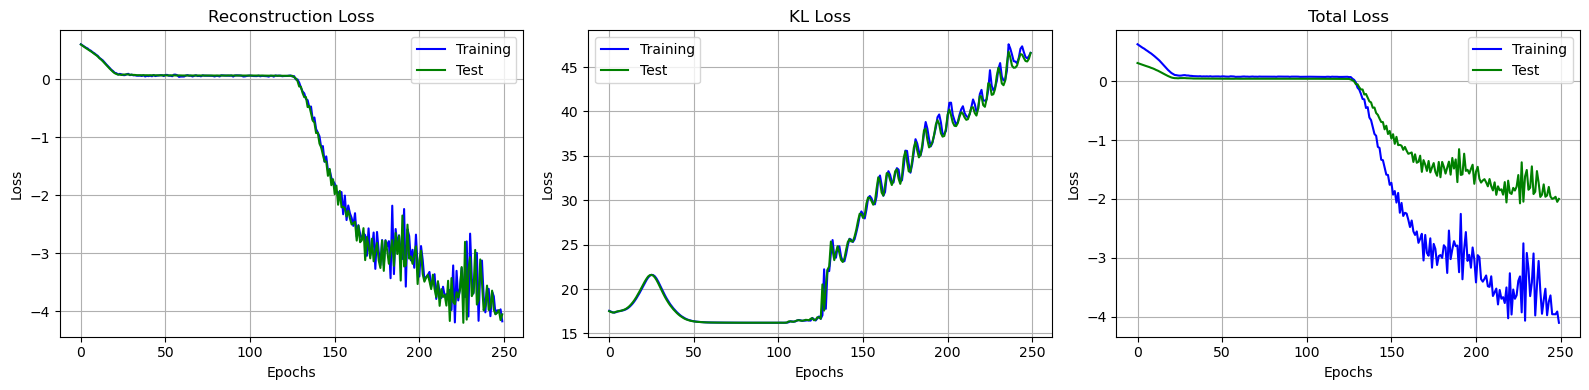

In [37]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

# Predictions

In [38]:
def sample_predictions(N_SAMPLES=3, model=dkf):
    
    idx = np.random.randint(0, len(X_valid), N_SAMPLES)
    X_valid_subset = X_valid[idx]
    y_valid_subset = y_valid[idx]
    
    fig, axs = plt.subplots(N_SAMPLES, 1, figsize=(16, 3 * N_SAMPLES))
    for i in range(N_SAMPLES):
        input = torch.tensor(X_valid_subset[i], device=device).unsqueeze(1).unsqueeze(2)
        # print(f"input shape : {input.shape}")
        target = torch.tensor(y_valid_subset[i], device=device)
        target = target.cpu().detach().numpy()
        predictions, logvar_predictions, all_xs, all_logvar_xs = model.predict(input, n_ahead)
        # print(f"predictions shape : {predictions.shape}")
        predictions = predictions.squeeze().cpu().detach().numpy()
        logvar_predictions = logvar_predictions.squeeze().cpu().detach().numpy()
        std_predictions = np.exp(logvar_predictions / 2)
        all_xs = all_xs.squeeze().cpu().detach().numpy()
        all_logvar_xs = all_logvar_xs.squeeze().cpu().detach().numpy()
        std_all_xs = np.exp(all_logvar_xs / 2)
        
        axs[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
        
        futures = np.arange(n_steps, n_steps+n_ahead)
        axs[i].scatter(futures, target, color='red', marker="x", linewidth=1, label="ground truth")
        axs[i].scatter(futures, predictions, color='green', marker="*", linewidth=1, label="prediction")
        
        all_times = np.arange(n_steps+n_ahead)
        axs[i].plot(all_times, all_xs, color='orange', marker="*", linewidth=1, label="reconstructed")
        axs[i].fill_between(all_times, all_xs-1*std_all_xs, all_xs+1*std_all_xs, color='orange', label='+/- 1 std', alpha=0.2)
        
        axs[i].set_title(f"Time series {idx[i]}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Value")
        axs[i].legend()
        axs[i].grid(True)
        
    plt.tight_layout()
    plt.show()

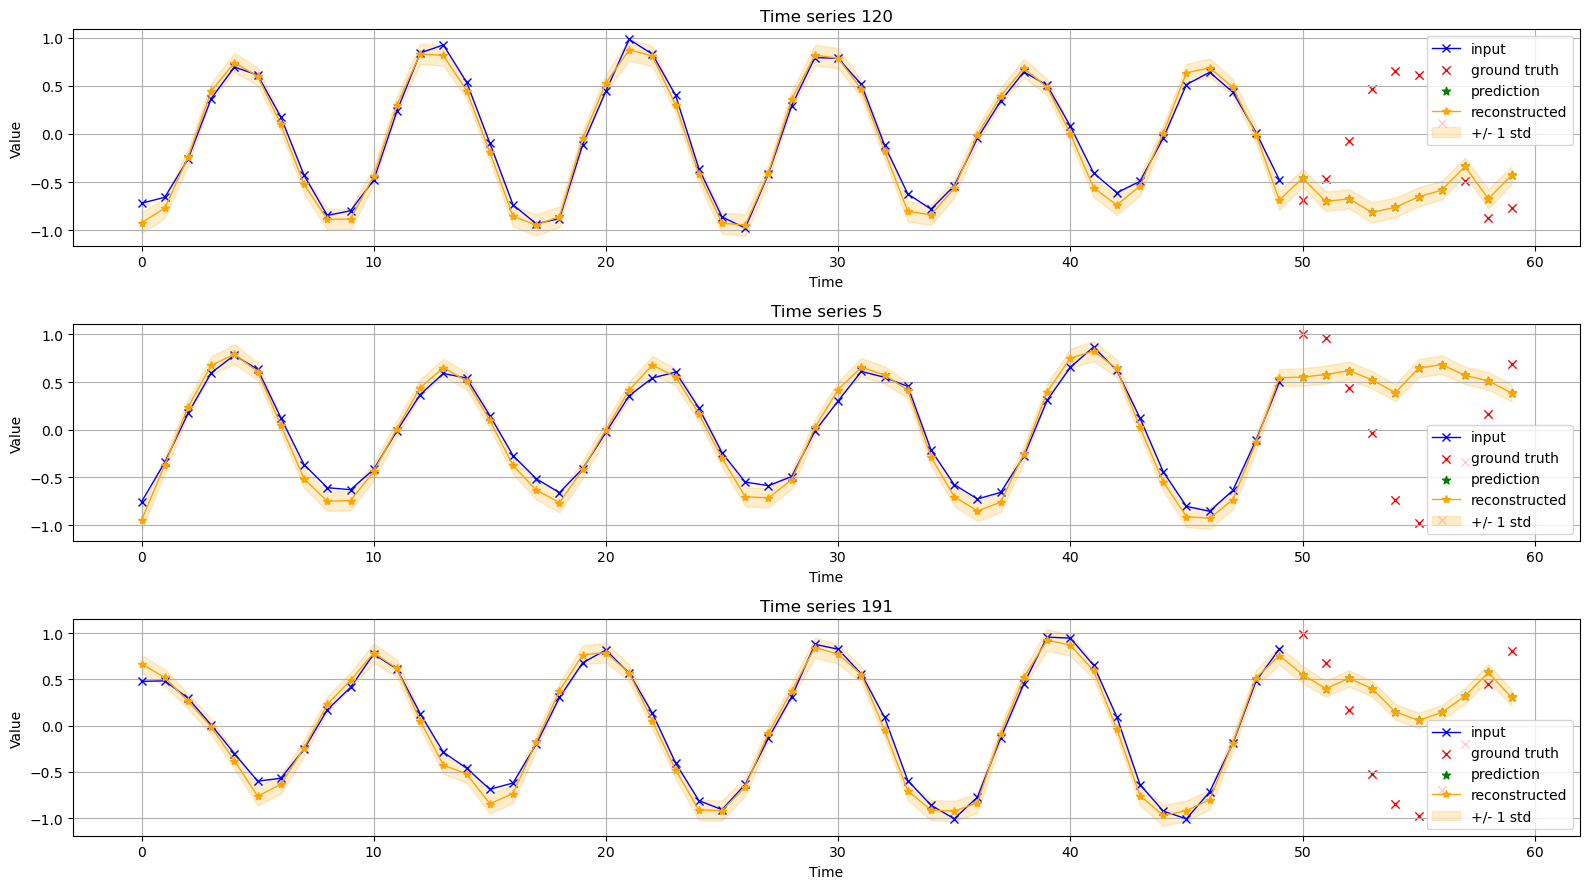

In [39]:
sample_predictions(N_SAMPLES=3, model=dkf)

# Questions !

Q1 - L'ELBO contient une expectation de KLs entre les vraies posterieures et les approximées. Une méthode est mentionnée p64 du papier de l'INRIA. Les loss que j'ai vues ne contiennent pas de calcul d'expectations.

Q2 - L'entraînement est fragile ! La loss est une combinaison linéaire reconstruction + $\beta$ * KL. 
- Si $\beta$ est trop grand, la reconstruction se fait mal, le modèle n'apprend pas le modèle d'observation. 
- Si $\beta$ est trop faible, le modèle n'apprend pas le modèle génératif, et donc les prédictions ! Il semble y avoir dans ce cas $\sigma_{\theta_x} \longrightarrow 0$, une loss de reconstruction qui tend vers $-\infty$, un "collapse" de la Gaussienne d'observation $p_{\theta_x}(x_t \vert z_t)$

Comment rendre l'entraînement robuste ?
  
Piste 1 : faire un scheduler sur $\beta$ ?

Piste 2 : retirer le terme $\log{\sigma_{\theta_x}^2}$ de la loss de reconstruction ?

Piste 3 : architecture réseaux : dropout, batchnorm, softplus pour logvar, lr...

Piste 4 : faire un beta scheduler intelligent qui détecte le collapse ?

Piste 5 : réfléchir ? (voir articles)

Articles sur le sujet (biblio papier INRIA):
- https://arxiv.org/pdf/1602.02282 (Ladder VAE)
- https://arxiv.org/pdf/2007.03898 (NVAE: A Deep Hierarchical Variational Autoencoder)


## Piste 1 : Implementing a simple linear Beta scheduler

Le training reste difficile à régler

In [40]:
class BetaLinearScheduler():
    """Scheduler linéaire simple du beta, rapport entre la loss de reconstruction et la loss KL
    """
    
    def __init__(self, beta_start=0.0, beta_end=1.0, num_epochs=100):
        """Constructeur

        Args:
            beta_start (float, optional): coefficient beta au démarrage. Defaults to 0.0.
            beta_end (float, optional): coefficient beta en fin de schedule. Defaults to 1.0.
            num_epochs (int, optional): nombre d'epochs sur lequel se fait l'évolution du beta. Defaults to 100.
        """
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.num_epochs = num_epochs
        
    def __call__(self, epoch):
        """Calcul du beta à l'epoch donnée

        Args:
            epoch (int): epoch courante

        Returns:
            float: beta
        """
        
        return self.beta_start + (self.beta_end - self.beta_start) * (np.min([epoch, self.num_epochs]) / self.num_epochs)

In [41]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = num_layers_rnn,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=16, hidden_dim=128, combiner_dim=8, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 128, num_layers=4)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=144, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
)
DecoderMLP(

In [42]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-3)
loss_fn = loss_function

num_epochs = 250
n_displays = 20  # nombre d'affichages souhaités
display_frequency = int(num_epochs / n_displays)

beta_scheduler = BetaLinearScheduler(beta_start=0.0, beta_end=1.0, num_epochs=50)  # warm up beta

In [43]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
    dkf, optimizer, loss_fn, num_epochs=num_epochs, beta_scheduler=beta_scheduler, display_frequency=display_frequency
)

Epoch    12/250 with beta = 2.20e-01 - TRAINING : Rec Loss: 3.1253e-01, KL Loss: 1.6528e+01, Total Loss: 3.2450e+00 - TEST : Rec Loss: 3.1334e-01, KL Loss: 1.6488e+01, Total Loss: 1.6150e+00
Epoch    24/250 with beta = 4.60e-01 - TRAINING : Rec Loss: 2.1454e-01, KL Loss: 1.6078e+01, Total Loss: 5.2120e+00 - TEST : Rec Loss: 2.1060e-01, KL Loss: 1.6073e+01, Total Loss: 2.6042e+00
Epoch    36/250 with beta = 7.00e-01 - TRAINING : Rec Loss: 1.2847e-01, KL Loss: 1.6022e+01, Total Loss: 6.6731e+00 - TEST : Rec Loss: 1.3056e-01, KL Loss: 1.6020e+01, Total Loss: 3.3367e+00
Epoch    48/250 with beta = 9.40e-01 - TRAINING : Rec Loss: 1.0607e-01, KL Loss: 1.6008e+01, Total Loss: 7.8064e+00 - TEST : Rec Loss: 9.9719e-02, KL Loss: 1.6007e+01, Total Loss: 3.9037e+00
Epoch    60/250 with beta = 1.00e+00 - TRAINING : Rec Loss: 8.2787e-02, KL Loss: 1.6004e+01, Total Loss: 8.0421e+00 - TEST : Rec Loss: 8.2629e-02, KL Loss: 1.6004e+01, Total Loss: 4.0217e+00
Epoch    72/250 with beta = 1.00e+00 - TRAINI

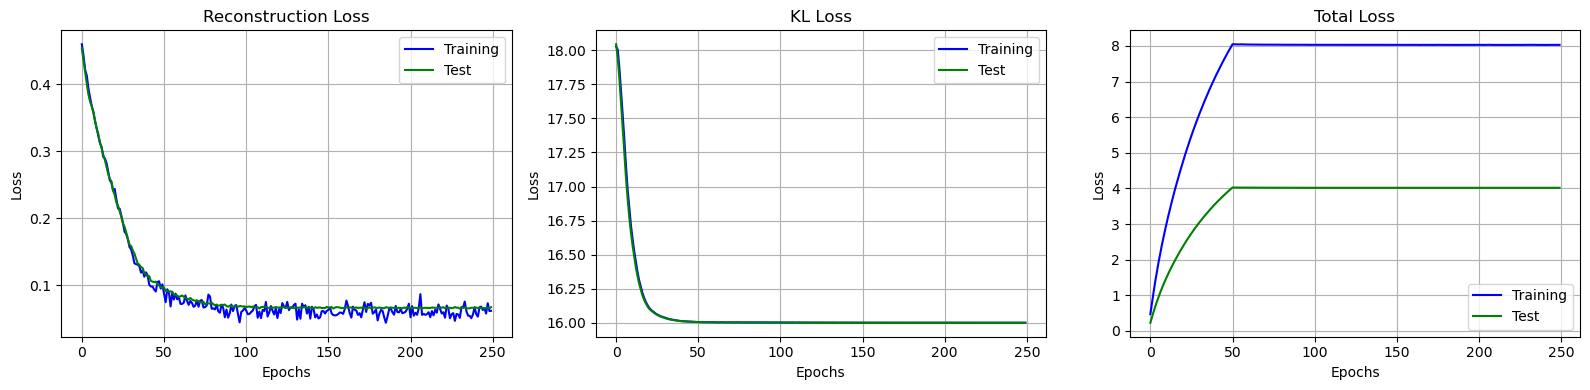

In [44]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

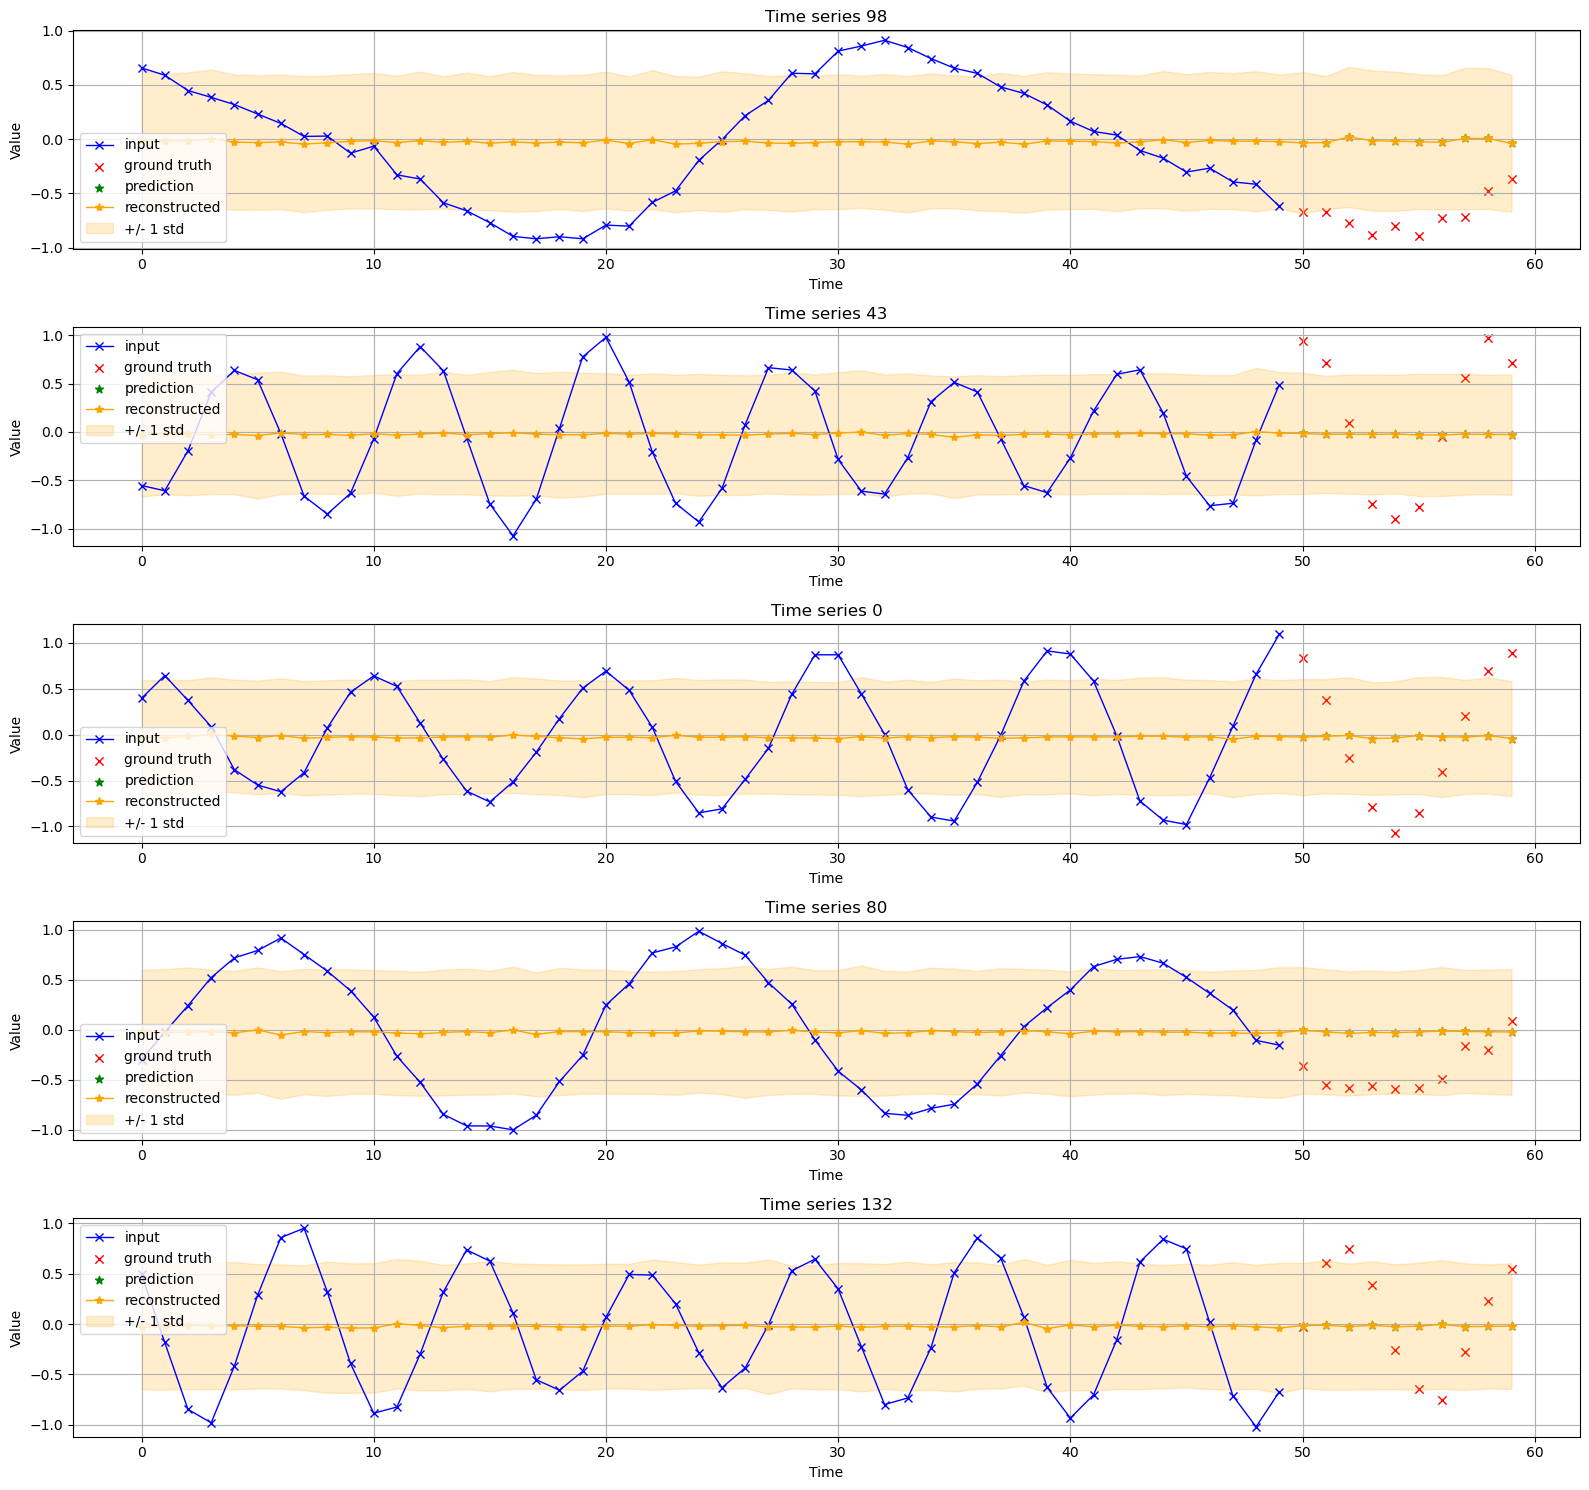

In [45]:
sample_predictions(N_SAMPLES=5, model=dkf)

## Piste 2 : retirer le terme qui fâche de la loss function...

Conclusion : le modèle d'observation (décodeur) apprend la moyenne de la Gaussienne, mais pas la variance, qui reste forte.

In [46]:
def loss_function_sans_log(x, x_hat, x_hat_logvar, z_mean, z_logvar,
                  z_transition_mean, z_transition_logvar, beta=None):
    """
    Compute the total loss for a variational autoencoder (VAE) with a weighted 
    reconstruction loss and a Kullback-Leibler (KL) divergence term.

    Parameters:
    -----------
    x : torch.Tensor
        Ground truth data with shape (seq_len, batch_size, x_dim).
    x_hat : torch.Tensor
        Reconstructed data from the VAE with shape
        (seq_len, batch_size, x_dim).
    x_hat_logvar : torch.Tensor
        Log variance of the reconstructed data with shape
        (seq_len, batch_size, x_dim).
    z_mean : torch.Tensor
        Mean of the latent variable distribution with shape 
        (seq_len, batch_size, x_dim).
    z_logvar : torch.Tensor
        Log variance of the latent variable distribution with shape 
        (seq_len, batch_size, x_dim).
    z_transition_mean : torch.Tensor
        Mean of the transition distribution in the latent space with shape 
        (seq_len, batch_size, x_dim).
    z_transition_logvar : torch.Tensor
        Log variance of the transition distribution in the latent space with 
        shape (seq_len, batch_size, x_dim).
    beta : float
        Weighting factor for the KL divergence term.
    loss_type : str
        Type of reconstruction loss to use. Options:
        - 'mse': Mean Squared Error (MSE) loss.
        - 'weighted_mse': Weighted Mean Squared Error (MSE) loss.

    Returns:
    --------
    total_loss : torch.Tensor
        The total loss, which is the sum of the reconstruction loss and the 
        KL divergence loss.

    Notes:
    ------
    - The "reconstruction loss" is based on formula above
    - The KL divergence loss measures the difference between the latent
      variable distribution and the transition distribution in the latent space.
    - Both losses are normalized by the sequence length (`seq_len`) and
      averaged over the batch.
    - The total loss is a combination of the reconstruction loss and the 
      KL divergence loss, weighted by the `beta` parameter.
    """
    
    # beta
    if beta is None:
        beta = 1.0
        
    seq_len, batch_size, x_dim = x.shape
    
    # Compute the reconstruction loss
    var = x_hat_logvar.exp()
    loss = torch.div((x - x_hat)**2, var)
            
    # le terme que l'on retire : loss += x_hat_logvar
    
    loss = loss.sum(dim=2)  # Sum over the x_dim
    loss = loss.sum(dim=0)  # Sum over the sequence length
    loss = loss.mean()  # Mean over the batch
    reconstruction_loss = loss / seq_len
           
    # Compute the KL divergence loss
    kl_loss = (z_transition_logvar - z_logvar +
               torch.div((z_logvar.exp() + 
                         (z_transition_mean - z_mean).pow(2)),
                         z_transition_logvar.exp()))
    
    kl_loss = kl_loss.sum(dim=2)  # Sum over the z_dim
    kl_loss = kl_loss.sum(dim=0)  # Sum over the sequence length
    kl_loss = kl_loss.mean()  # Mean over the batch
    kl_loss = kl_loss / seq_len
                
    # Combine the reconstruction loss and the KL divergence loss
    total_loss = (reconstruction_loss + beta * kl_loss)/(1+beta)
    
    return reconstruction_loss, kl_loss, total_loss

In [47]:
dkf = DeepKalmanFilter(
    input_dim = xdim,
    latent_dim = latent_dim,
    hidden_dim = h_dim,
    combiner_dim = combiner_dim,
    num_layers = num_layers_rnn,
    device=device
).to(device)

print(dkf)

DeepKalmanFilter(input_dim=1, latent_dim=16, hidden_dim=128, combiner_dim=8, inter_dim=16)
BackwardLSTM(
  (lstm): LSTM(1, 128, num_layers=4)
)
CombinerMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=144, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
)
EncoderMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
)
LatentSpaceTransitionMLP(
  (activation_fn): Tanh()
  (mlp): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
)
DecoderMLP(

In [48]:
optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-3)
loss_fn = loss_function_sans_log

num_epochs = 20
display_frequency = int(num_epochs / 20)

beta_scheduler = BetaLinearScheduler(beta_start=0.0, beta_end=1.0, num_epochs=10)

In [49]:
# rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
#     dkf, optimizer, loss_fn, num_epochs=num_epochs, beta_scheduler=beta_scheduler, display_frequency=display_frequency
# )

In [50]:
# plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

In [51]:
# sample_predictions(N_SAMPLES=6, model=dkf)

## Piste 3 : Paramètres réseau : lr, batch_size

In [52]:
# BATCH_SIZE = 64   # 8192 ok sur RTX3080 et 150 time steps

# train_dataset = TimeSeriesDataset(X_train, y_train)
# test_dataset = TimeSeriesDataset(X_valid, y_valid)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [53]:
# dkf = DeepKalmanFilter(
#     input_dim = xdim,
#     latent_dim = latent_dim,
#     hidden_dim = h_dim,
#     combiner_dim = combiner_dim,
#     num_layers = 1,
#     device=device
# ).to(device)

# print(dkf)

In [54]:
# optimizer = torch.optim.Adam(dkf.parameters(), lr=1e-3)
# loss_fn = loss_function

# num_epochs = 250
# display_frequency = int(num_epochs / 20)

# beta_scheduler = BetaLinearScheduler(beta_start=0.0, beta_end=0.65, num_epochs=150)

In [55]:
# rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses = train(
#     dkf, optimizer, loss_fn, num_epochs=num_epochs, beta_scheduler=beta_scheduler, display_frequency=display_frequency
# )

In [56]:
# plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses)

In [57]:
# sample_predictions(N_SAMPLES=6, model=dkf)